# Importing relevant libraries

In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np
from sklearn.externals import joblib

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Importing the dataset

In [2]:
df = pd.read_excel('inflation.xlsx', index_col = 'Years')



In [3]:
df.describe()

,inflation
count,3.600000e+01
mean,6.421118e+06
std,3.852510e+07
min,-2.400000e+00
25%,8.725000e+00
50%,1.920000e+01
75%,5.647500e+01
max,2.311509e+08


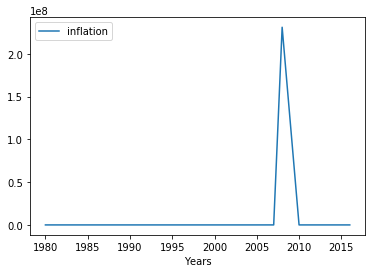

In [4]:
df.plot()

In [5]:
df.isnull().sum()

inflation    0
dtype: int64

In [6]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [7]:
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

inflation    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D5BFA41C18>]],
      dtype=object)

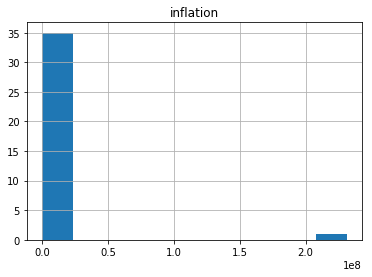

In [10]:
df.hist(bins=10)

In [11]:
len(df[df['inflation'] == 0])

0

In [12]:
print('Min', np.min(df))
print('Max', np.max(df))

Min inflation   -2.4
dtype: float64
Max inflation    231150889.4
dtype: float64


In [13]:
dataset = df.astype('float32')

In [14]:
dataset.shape

(36, 1)

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

In [16]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [17]:
print(scaled[:10])

[[4.19639307e-08]
 [7.05167050e-08]
 [7.35450331e-08]
 [9.51759246e-08]
 [8.08995313e-08]
 [5.01836678e-08]
 [7.18145593e-08]
 [6.18643484e-08]
 [4.10986938e-08]
 [6.05664982e-08]]


In [18]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 25
test: 11


In [19]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

25 1
0
X 0 to 1
[4.19639307e-08]
Y 1
7.051670500406628e-08
1
X 1 to 2
[7.0516705e-08]
Y 2
7.354503311260827e-08
2
X 2 to 3
[7.35450331e-08]
Y 3
9.517592459782171e-08
3
X 3 to 4
[9.51759246e-08]
Y 4
8.089953126666268e-08
4
X 4 to 5
[8.08995313e-08]
Y 5
5.0183667833118675e-08
5
X 5 to 6
[5.01836678e-08]
Y 6
7.181455931833212e-08
6
X 6 to 7
[7.18145593e-08]
Y 7
6.186434840998091e-08
7
X 7 to 8
[6.18643484e-08]
Y 8
4.1098693821905544e-08
8
X 8 to 9
[4.10986938e-08]
Y 9
6.05664982214802e-08
9
X 9 to 10
[6.05664982e-08]
Y 10
7.743859192964064e-08
10
X 10 to 11
[7.74385919e-08]
Y 11
1.111827793459615e-07
11
X 11 to 12
[1.11182779e-07]
Y 12
1.9251492802975193e-07
12
X 12 to 13
[1.92514928e-07]
Y 13
1.2978535097416322e-07
13
X 13 to 14
[1.29785351e-07]
Y 14
1.0685660104891882e-07
14
X 14 to 15
[1.06856601e-07]
Y 15
1.0815445948894978e-07
15
X 15 to 16
[1.08154459e-07]
Y 16
1.0296304223188645e-07
16
X 16 to 17
[1.02963042e-07]
Y 17
9.17149770092694e-08
17
X 17 to 18
[9.1714977e-08]
Y 18
1.475226

In [21]:
X_train.shape

(23, 1)

In [22]:
y_test.shape

(9,)

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(23, 1, 1)
(9, 1, 1)


In [24]:
np.random.seed(9)

In [25]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
history = model.fit(X_train, y_train, epochs=22, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/22
 - 3s - loss: 1.6104e-06 - mean_squared_error: 1.6104e-06
Epoch 2/22
 - 0s - loss: 5.1534e-06 - mean_squared_error: 5.1534e-06
Epoch 3/22
 - 0s - loss: 7.6024e-06 - mean_squared_error: 7.6024e-06
Epoch 4/22
 - 0s - loss: 6.3512e-06 - mean_squared_error: 6.3512e-06
Epoch 5/22
 - 0s - loss: 3.5719e-06 - mean_squared_error: 3.5719e-06
Epoch 6/22
 - 0s - loss: 2.1308e-06 - mean_squared_error: 2.1308e-06
Epoch 7/22
 - 0s - loss: 1.3329e-06 - mean_squared_error: 1.3329e-06
Epoch 8/22
 - 0s - loss: 6.5961e-07 - mean_squared_error: 6.5961e-07
Epoch 9/22
 - 0s - loss: 3.2362e-07 - mean_squared_error: 3.2362e-07
Epoch 10/22
 - 0s - loss: 2.4088e-07 - mean_squared_error: 2.4088e-07
Epoch 11/22
 - 0s - loss: 1.1260e-07 - mean_squared_error: 1.1260e-07
Epoch 12/22
 - 0s - loss: 9.3687e-08 - mean_squared_error: 9.3687e-08
Epoch 13/22
 - 0s - loss: 5.1319e-08 - mean_squared_error: 5.1319e-08
Epoch 14/22
 - 0s - loss: 3.9498e-08 - mean_squared_error: 3.9498e-08
Epoch 15/22
 - 0s - loss: 3.2

In [26]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 37473.16 RMSE
Test Score: 77619804.11 RMSE


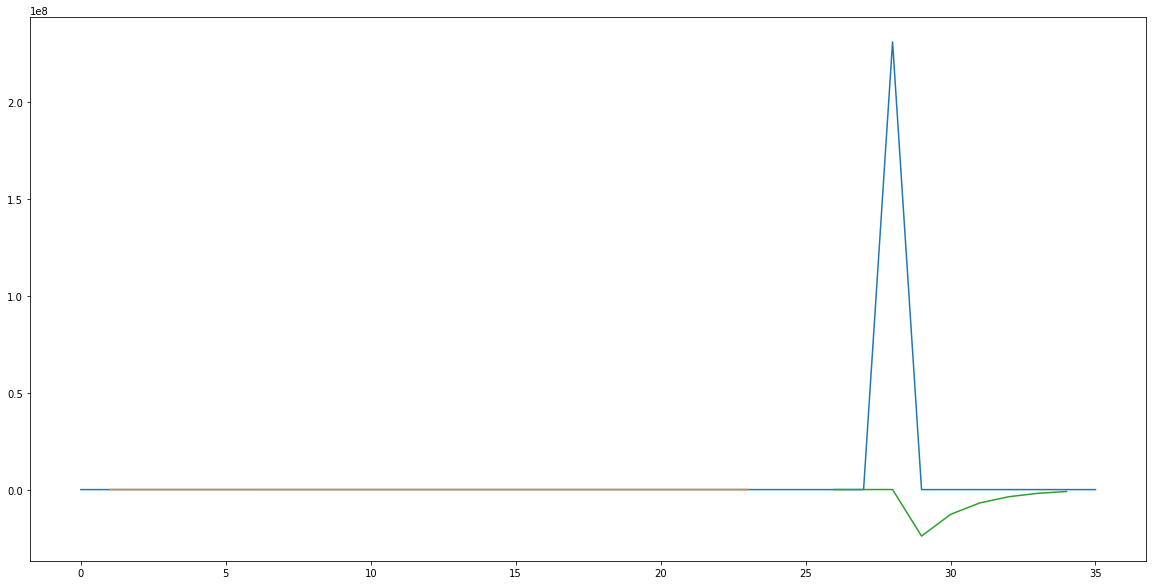

In [27]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [28]:
v = [3]
x = np.asarray(v)
x

array([3])

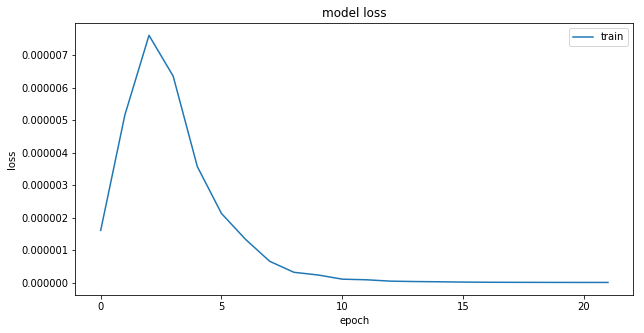

In [31]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [29]:
x = np.reshape(x,(-1,1))

In [40]:
inp = scaler.fit_transform(x)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [41]:
inp = np.reshape(inp, (inp.shape[0], inp.shape[1], 1))

In [42]:
inp.shape

(1, 1, 1)

In [43]:
pred = model.predict(inp)

In [44]:
pred

array([[-0.00083412]], dtype=float32)

In [45]:
pred = scaler.inverse_transform(pred)

In [46]:
pred

array([[2.9991658]], dtype=float32)

In [37]:
joblib.dump(model, 'inflation_model.pkl')

['inflation_model.pkl']